# Image Segmentation with skimage

Using the tutorial here: https://www.youtube.com/watch?v=pZATswy_IsQ and github: https://github.com/orrbeer/https-github.com-scikit-image-skimage-tutorials/blob/master/lectures/4_segmentation.ipynb

Extract or identify a subset of data that is interesting by seperating an image into one or more regions of interest. I want a face, an organ, a cell, whatever! 

I will look at supervised and unsupervised segmentation. 

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import skimage.data as data
import skimage.segmentation as seg
import skimage.filters as filters
import skimage.draw as draw
import skimage.color as color

# convenience function for plotting
def image_show(image, nrows=1, ncols=1, cmap='gray', **kwargs):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16,16))
    ax.imshow(image, cmap=cmap)
    ax.axis('off')
    return fig, ax

### Thresholding
It is the simplest way to segment objects from a background by choosing pixels above or below a certain threshold.

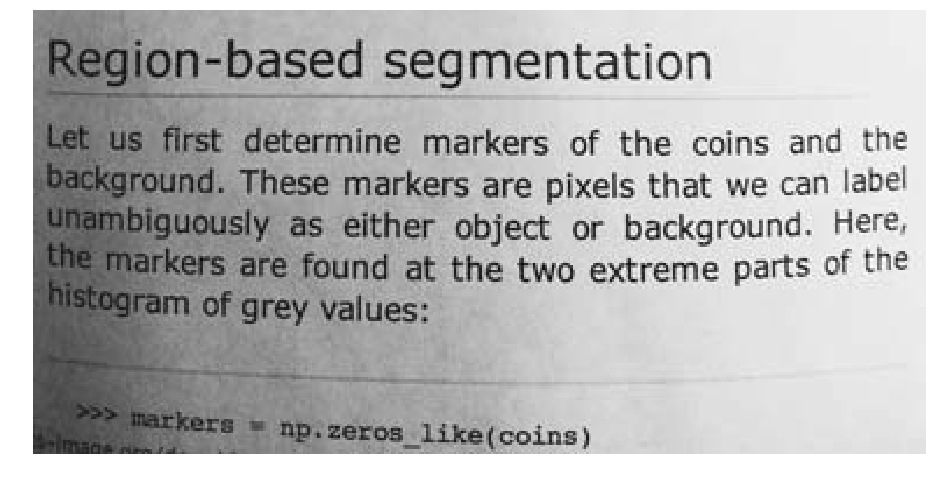

In [13]:
text = data.page()
image_show(text);

Let's find a useful value for finding a threshold between pixels on the image. We will use a histogram for this to plot the number of times values within a certain range appear. 

Use `numpy.ravel()` to create a 1-D array.

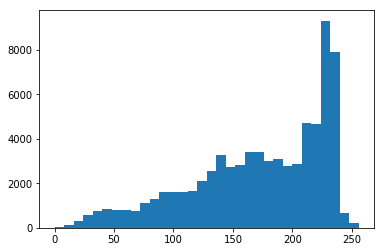

In [13]:
fig, ax = plt.subplots(1,1)
ax.hist(text.ravel(), bins=32, range=[0,256]);

An ideal segmentation case is bimodal. This one is quite tricky.

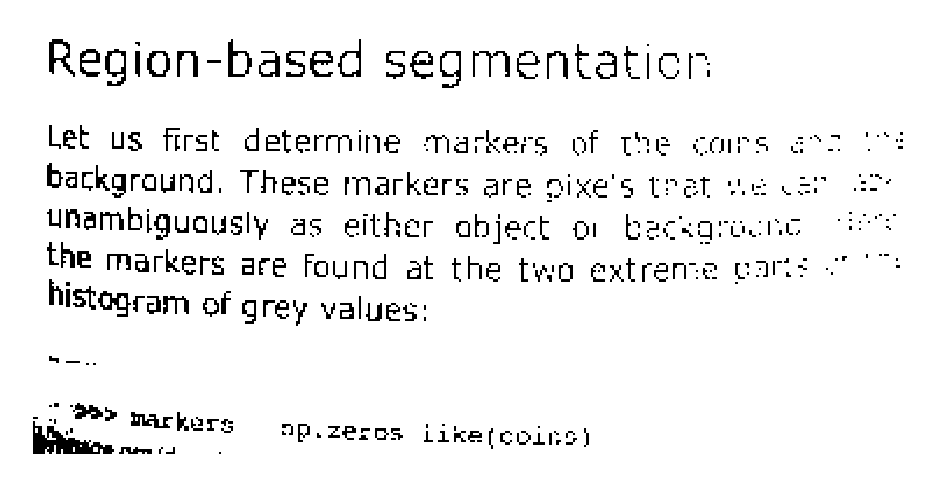

In [20]:
text_segmented = text > 70 # a simple threshold/supervised chosen by me
image_show(text_segmented);

157


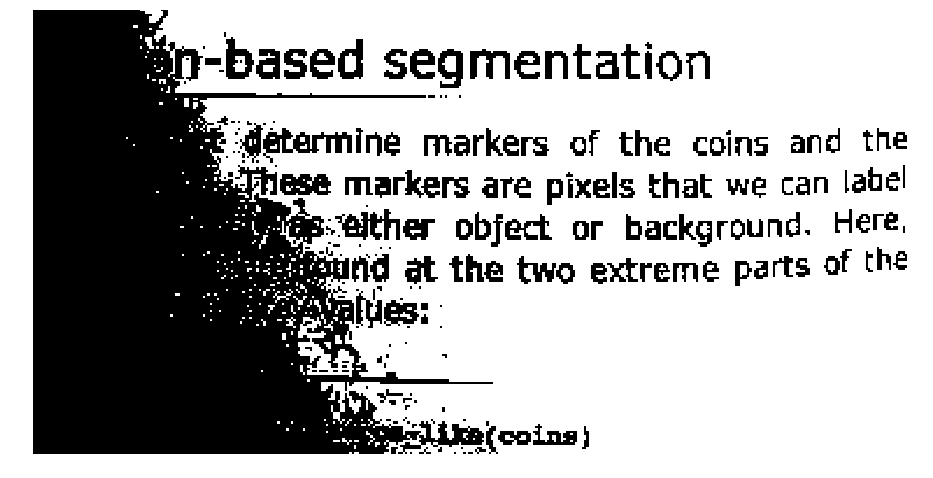

In [24]:
text_threshold = filters.threshold_otsu(text) # a calculated threshold
print(text_threshold)
image_show(text > text_threshold);

Compute a threshold mask image based on local pixel neighbourhood. Must use odd size of pixel neighbourhood for **block_size**.  Gaussian filter is used as default. **Offset** is really useful, it is a constant substracted from the weighted mean. 

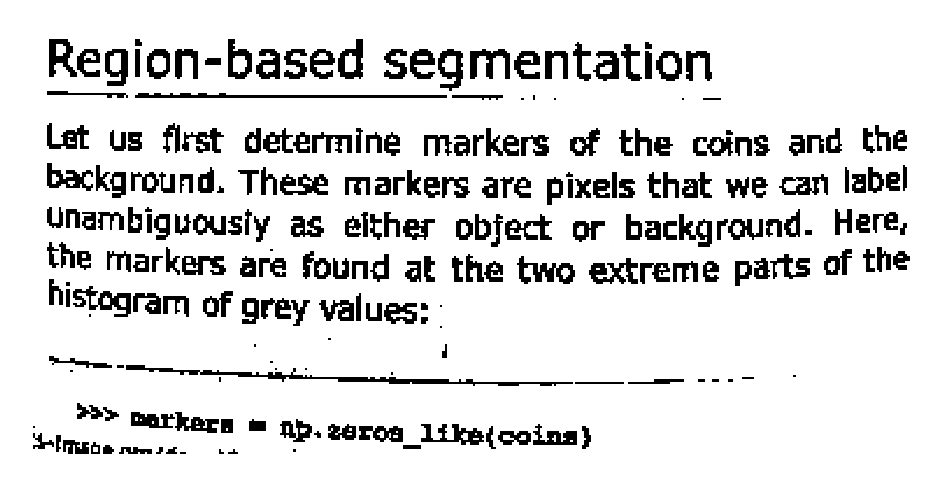

In [15]:
text_threshold2 = filters.threshold_local(text, 53, offset=10)
#print(text_threshold2)
image_show(text > text_threshold2);

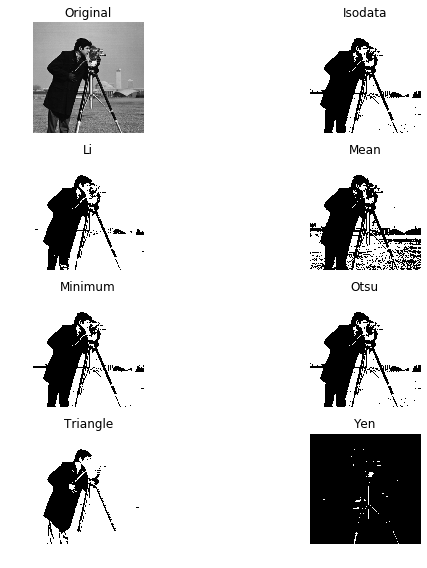

In [17]:
from skimage.filters import try_all_threshold
img = data.camera()
fig, ax = try_all_threshold(img, figsize=(10,8), verbose=False)
plt.show()
# source: https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_thresholding.html

How do you quantatively say we have a good result?

If you want to measure the predicted results against expected result then you can look at methods of [scikit-image.measure](https://scikit-image.org/docs/dev/api/skimage.measure.html). Ground truth is the best method - compare your result against a ground truth. You could also look at local entropy or local variation to help determine whether you still have some noise around.

### Supervised segmentation
Much more useful for real imagery e.g. picture of a room, person. Anything that has high-contrast.

It is a **good idea to remove any noise** in an image before carrying out segmentation. 

Input rgb image and convert to grayscale.

In [42]:
astronaut = data.astronaut()
astronaut_gray = color.rgb2gray(astronaut)

**Active contour segmentation**

Finding a hard edge in the image by fitting contours (aka snakes).

Start by initialising the snake by drawing a circle around the area of interest in this case the astronauts head

In [33]:
def circle_points(resolution, centre, radius):
    '''
    Generate points defining the circle of an image
    
    centre as (x,y) coordinates
    
    Hint for equation: https://www.mathopenref.com/coordparamcircle.html
    '''
    radians = np.linspace(0, 2*np.pi, resolution)
    
    c = centre[1] + radius*np.cos(radians)
    r = centre[0] + radius*np.sin(radians)
    
    return np.array([c,r]).T

# no need for final position, it's a duplicate point
points = circle_points(200, [100,220], 100)[:-1] 

In [38]:
snake = seg.active_contour(astronaut_gray, points, alpha=0.1)

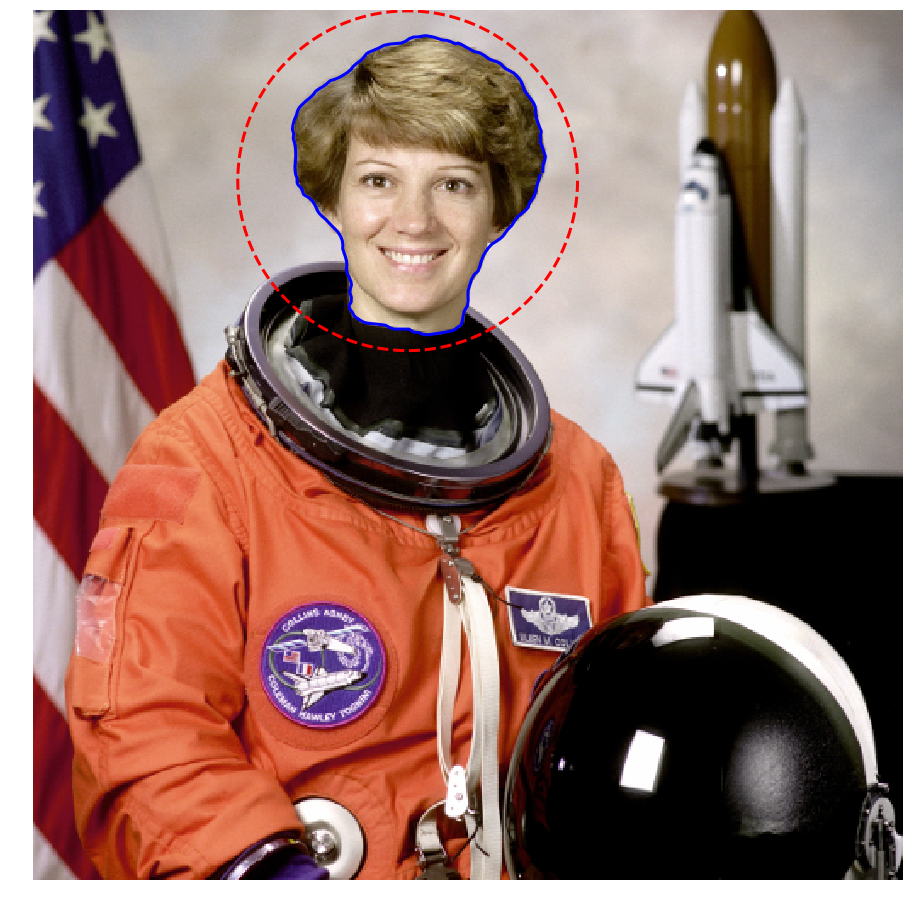

In [39]:
fig, ax = image_show(astronaut)
ax.plot(points[:, 0], points[:,1], '--r', lw=3)
ax.plot(snake[:, 0], snake[:,1], '-b', lw=3);

**Random Walker**

Random pixels with labelling sprinkled throughout the image. 

The distance from each pixel to its neighours is weighted by how similar their value are; the more similar then the lower the cost is to step from one to the other. 

The algorithm finds the cheapest path from each point to each seed value. 

In [46]:
astronaut_labels = np.zeros(astronaut_gray.shape, dtype=np.uint8)

In [56]:
indices = draw.circle_perimeter(100,220,25)

astronaut_labels[indices] = 1
astronaut_labels[points[:,1].astype(np.int), 
                 points[:,0].astype(np.int)] = 2
# image_show(astronaut_labels);

In [65]:
astronaut_segmented = seg.random_walker(astronaut_gray, 
                                        astronaut_labels,
                                        beta=3500)

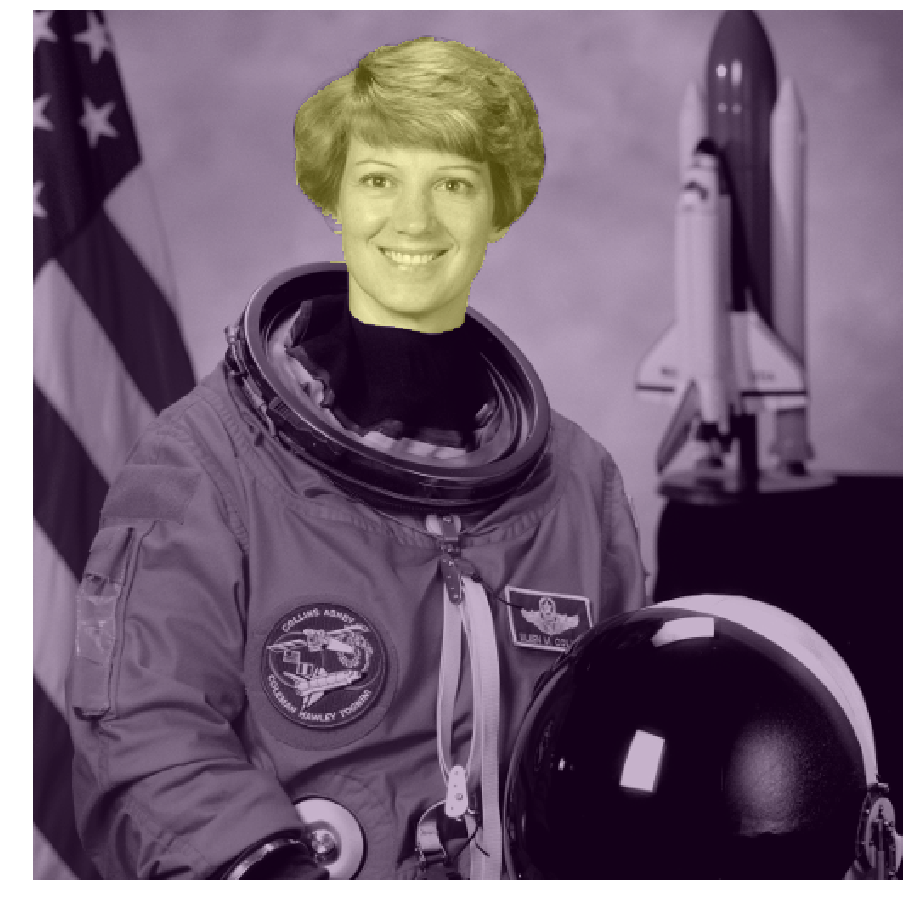

In [66]:
fig, ax = image_show(astronaut_gray)
ax.imshow(astronaut_segmented==1, alpha=0.3);